In [14]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [15]:
dataset = xr.open_dataset("tco300_omimls_oct2004_to_dec2024_1by1.nc")

OMI/MLS Ground-to-300hPa Column Ozone for TOARII *y_elements: latitude, x_elements: longitude, period: October 2004 - December 2024

So now it is time for some data cleaning, there should not be negative values in the data

In [16]:
ozone_data = dataset["TropoO3"]
cleaned_ozone_dataset = ozone_data.where(ozone_data >= 0)
dataset["TropoO3"] = cleaned_ozone_dataset

In [17]:
dataset["TropoO3"]

<xarray.DataArray 'TropoO3' (months: 243, y_elements: 180, x_elements: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Dimensions without coordinates: months, y_elements, x_elements
Attributes:
    units:      Dobson Units
    name:       Tropo O3 Gnd-to-Tropopause
    latitude:   -89.5, -88.5, ..., 89.5
    longitude:  -179.5, -178.5, ..., 179.5
    Month:      Oct2004, Nov2004, ..., Dec2024

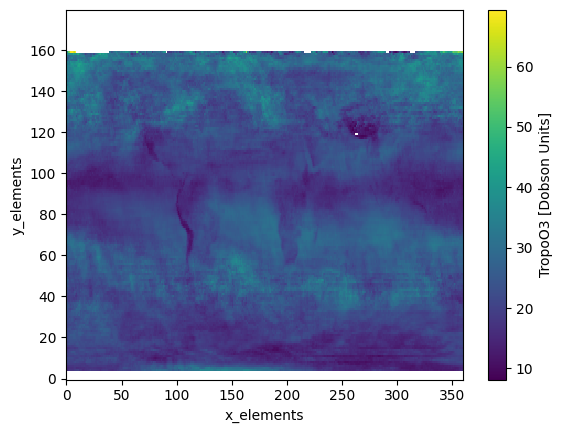

In [18]:
dataset.TropoO3[181].plot()

Try to visualize this cleaned data now for arbitrary month

In [19]:
dataset.head()

<xarray.Dataset>
Dimensions:  (months: 5, y_elements: 5, x_elements: 5)
Dimensions without coordinates: months, y_elements, x_elements
Data variables:
    TropoO3  (months, y_elements, x_elements) float32 nan nan ... 11.22 10.18
Attributes:
    Title:    OMI/MLS Ground-to-300hPa Column Ozone for TOARII, etc.

C:\Users\19294\AppData\Local\Temp\ipykernel_1680\650155074.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(projection=ccrs.PlateCarree())


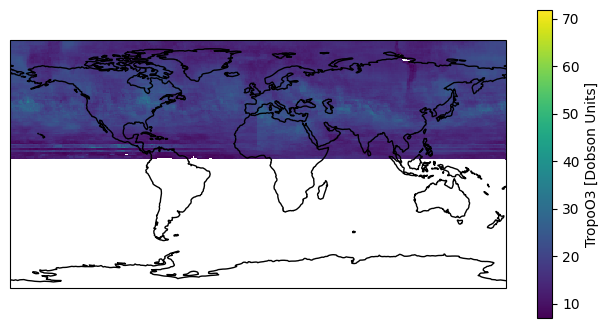

In [20]:
# plot arbitrary month
i = 160
ozone_month = dataset["TropoO3"].isel(months=i)

fig = plt.subplots(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ozone_month.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree())

plt.show()

In [21]:
# create separate datetime64 object, just so we can group ozone by month 

start_date = '2004-10-01'
end_date = '2024-12-31'
total_months_available = len(dataset.months)

time_coords = pd.date_range(start=start_date, periods=total_months_available, freq='MS')

ozone = dataset['TropoO3']

total_na = ozone.isnull().sum()
ozone = ozone.assign_coords(time=('months', time_coords))
monthly_mean = ozone.groupby('time.month').mean('months')

In [22]:
print(monthly_mean.mean())

<xarray.DataArray 'TropoO3' ()>
array(23.230068, dtype=float32)


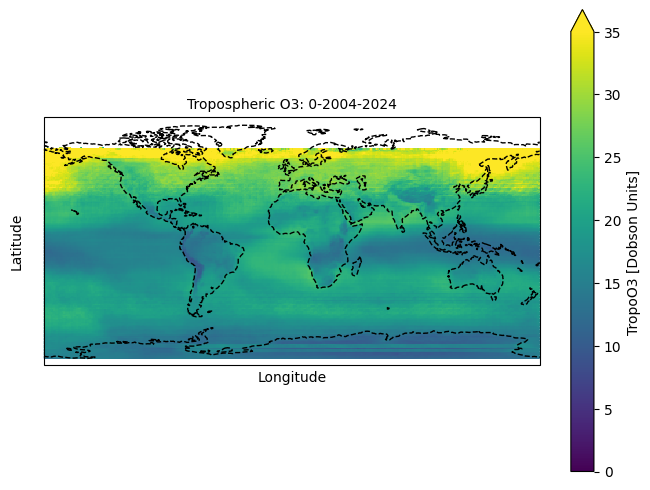

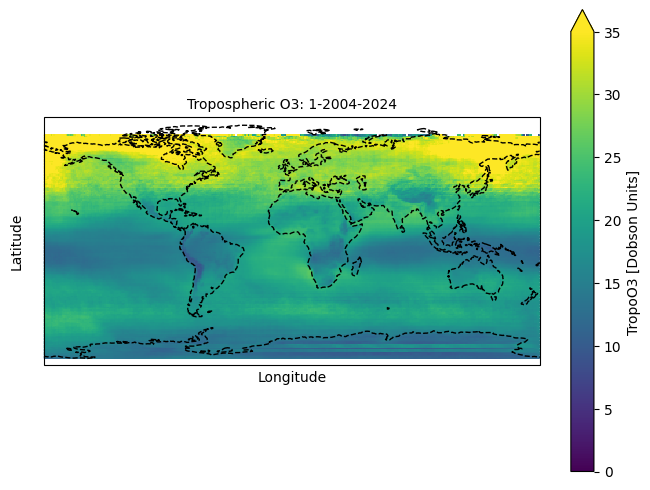

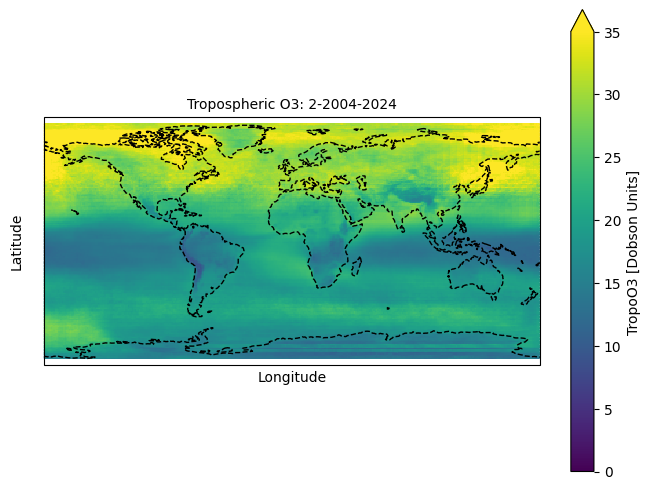

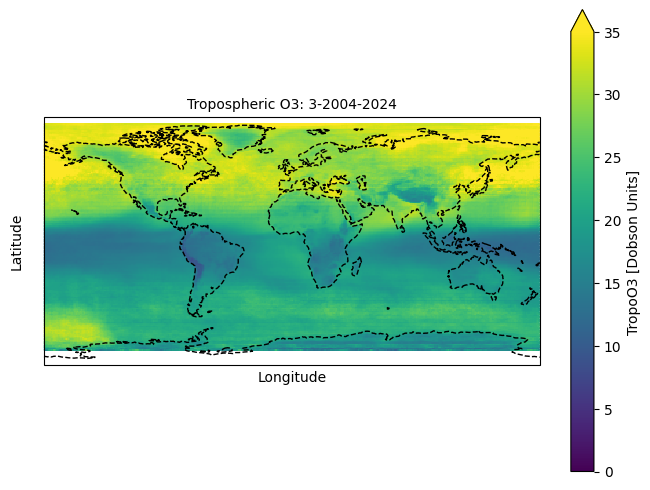

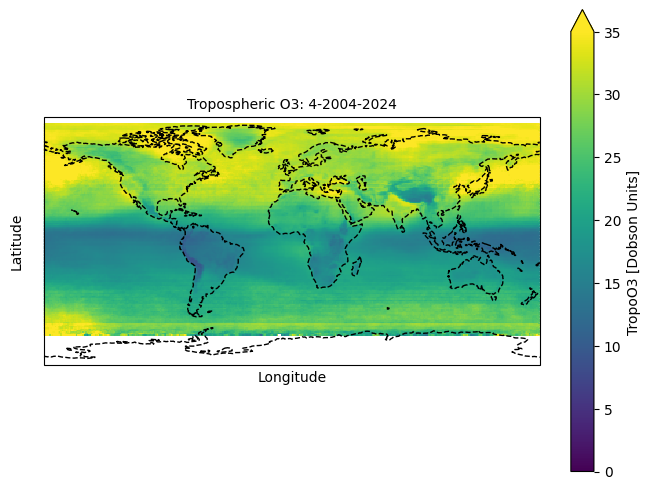

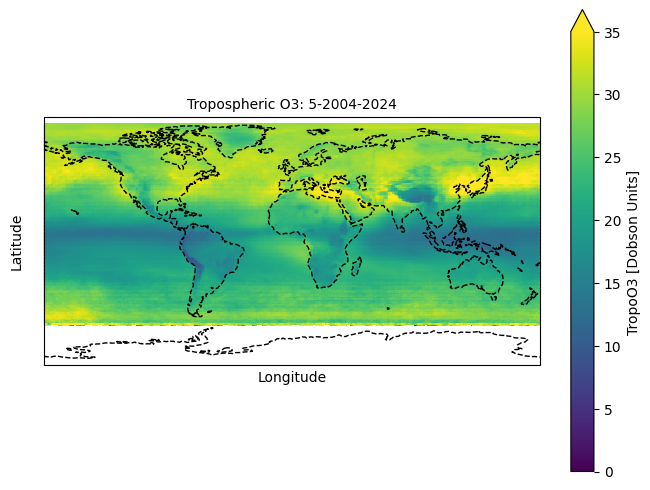

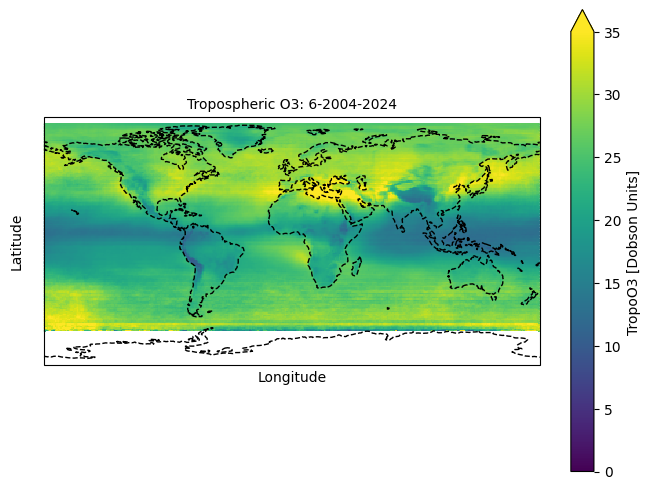

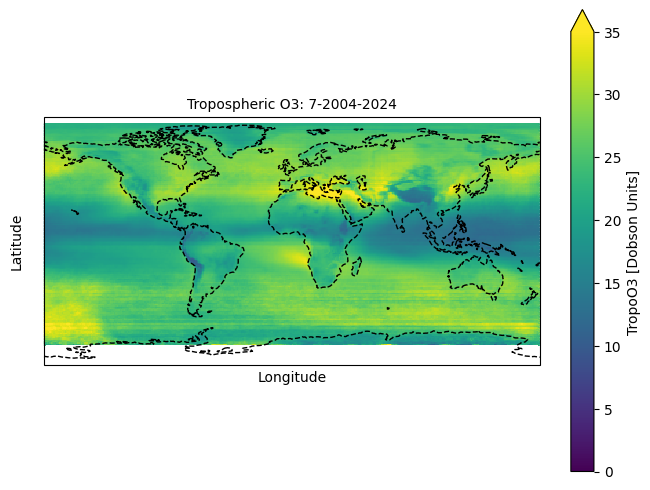

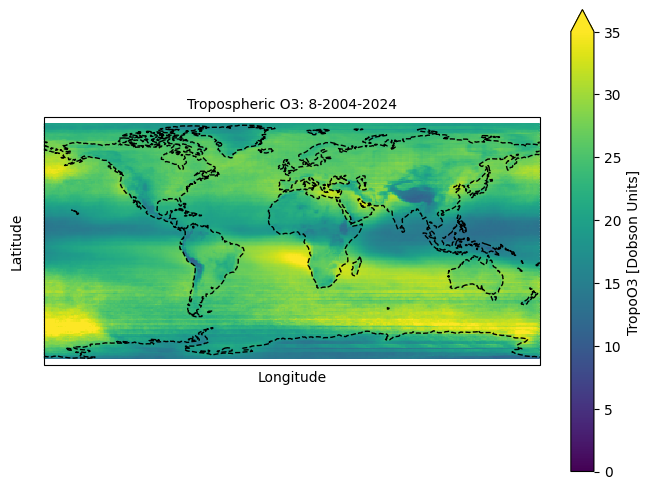

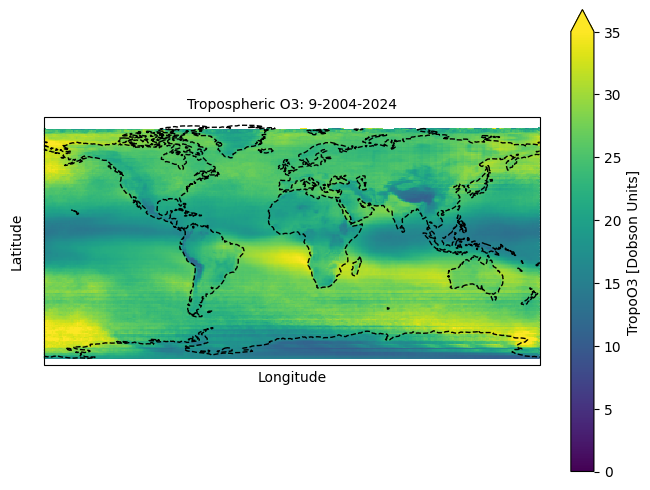

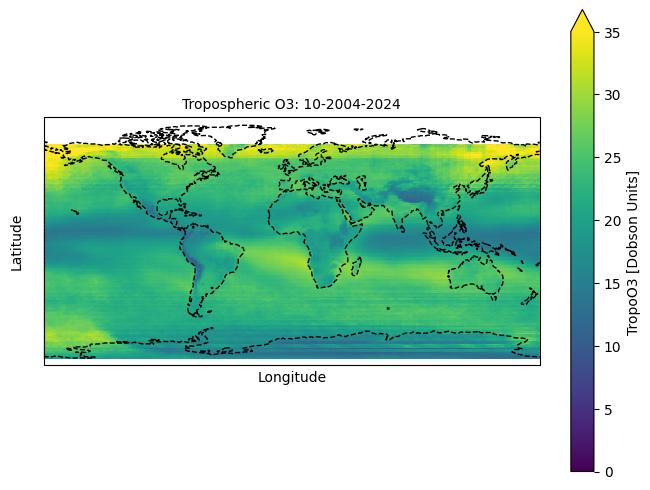

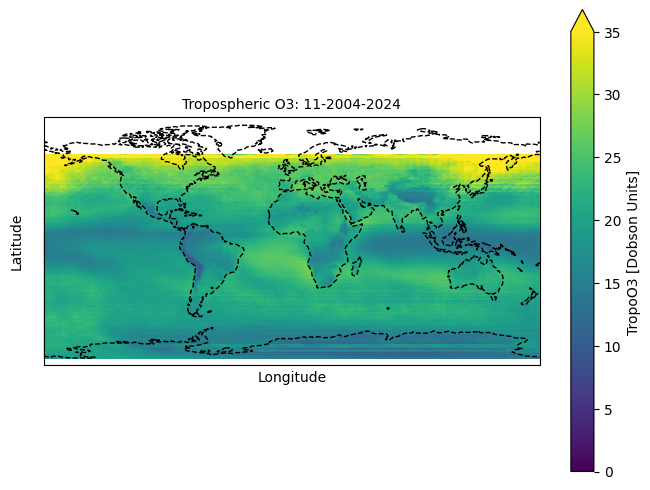

In [23]:
# plot the monthly means

lon_coords = np.arange(0.5, 360.5, 1)
lat_coords = np.arange(-89.5,90.5, 1)

monthly_mean = monthly_mean.assign_coords(
    longitude=('x_elements', lon_coords),
    latitude=('y_elements', lat_coords)
)

for i in range(12):
    plt.figure(figsize=(8,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    monthly_mean[i].plot(ax=ax,transform=ccrs.PlateCarree(central_longitude=180), x='longitude', y='latitude', vmin=0, vmax=35)
    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_global()

    ax.set_title('Tropospheric O3: ' + str(i) + '-2004-2024', fontsize=10)
    ax.text(-0.04, 0.5, 'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)
    ax.text(0.5, -0.08, 'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes)

    plt.savefig("Monthly_Mean_TropoO3-" + str(i))
    plt.show()

In [27]:
import imageio
import os

def create_gif(image_folder, output_gif, duration):
    filenames = sorted([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
    images = []
    for filename in filenames:
        if filename.lower().endswith('.png'):
            image_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(image_path))
    imageio.mimsave(output_gif, images, duration=duration)

image_dir = 'C:\\Users\\19294\\Documents\\GitHub\\SOARS2025\\workspace\\'
gif_file = "TropoO3climatology.gif"


create_gif(image_dir, gif_file, duration=500)

C:\Users\19294\AppData\Local\Temp\ipykernel_1680\2327335926.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))
